In [ ]:
# Justin Zarkovacki    12/07/2022

# Transfer Learning Notebook

In [1]:
import numpy as np
import os
import optuna
import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, AveragePooling2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Rescaling
from keras import Input, models, backend as K
from tensorflow.keras import layers, models

print("Done!")

Done!


# Function Definitions and Variables

In [2]:
epochs = 12
img_rows, img_cols = 28, 28  # Image dimensions

def load(f):
    return np.load(f)['arr_0']
    
def initialize_data(train_im_file, test_im_file, train_lb_file, test_lb_file):
    train_images = load(train_im_file)
    test_images = load(test_im_file)
    train_labels = load(train_lb_file)
    test_labels = load(test_lb_file)
    
    if K.image_data_format() == 'channels_first':
        train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
        test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
        test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images /= 255
    test_images /= 255
    print('{} train samples, {} test samples'.format(len(train_images), len(test_images)))
    
    return tuple([train_images, test_images, train_labels, test_labels, input_shape])

# Helper to create the graphics
def create_visuals(graph_title, model_hist, test_images, test_labels):
    accuracy_data = model_hist.history['accuracy']
    val_accuracy_data = model_hist.history['val_accuracy']

    lower_bound = min(min(accuracy_data), min(val_accuracy_data))

    plt.plot(accuracy_data, label='Train Accuracy')
    plt.plot(val_accuracy_data, label = 'Validation Accuracy')

    plt.title(graph_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([lower_bound - 0.01, 1])
    plt.legend(loc='lower right')

    print(accuracy_data[-1])
    print(val_accuracy_data[-1])
#     test_loss, test_acc = model_hist.evaluate(test_images, test_labels, verbose=2)

print("Done!")

Done!


## Load Data

In [3]:
prefix = '..\..\Datasets\\'
datasets = {
    "k49_tr_i" : prefix + 'Kuzushiji-49 - train-imgs.npz',
    "k49_te_i" : prefix + 'Kuzushiji-49 - test-imgs.npz',
    "k49_tr_l" : prefix + 'Kuzushiji-49 - train-labels.npz',
    "k49_te_l" : prefix + 'Kuzushiji-49 - test-labels.npz',
    "kanji" : prefix + 'modified_final_dataset',
}

# Load Kuzushiji-49 Data
dataset = initialize_data(datasets["k49_tr_i"], datasets["k49_te_i"], datasets["k49_tr_l"], datasets["k49_te_l"])
k49_train_images = dataset[0]
k49_test_images = dataset[1]
k49_train_labels = dataset[2]
k49_test_labels  = dataset[3]
k49_input_shape = dataset[4]

# Load Kanji Data
kanji_size = (28, 28)
data_path = datasets["kanji"]
kanji_train = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                            subset="training", color_mode="grayscale", image_size=kanji_size, batch_size=32)

kanji_val = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                          subset="validation", color_mode="grayscale", image_size=kanji_size, batch_size=32)

print("Done!")

232365 train samples, 38547 test samples
Found 70599 files belonging to 150 classes.
Using 49420 files for training.
Found 70599 files belonging to 150 classes.
Using 21179 files for validation.
Done!


### Rescale Kanji Data and Training Performance Optimizations

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = kanji_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))    # Pixel values are now in `[0,1]`

0.0 1.0


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

kanji_train = kanji_train.cache().prefetch(buffer_size=AUTOTUNE)
kanji_val = kanji_val.cache().prefetch(buffer_size=AUTOTUNE)
print("Done!")

Done!


## K49 Base Model and Results for Image Size (28, 28)

In [8]:
k49_classes = 49

k49_2 = Sequential()
k49_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Conv2D(64, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Dropout(0.25))
k49_2.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
k49_2.add(Conv2D(48, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Flatten())
k49_2.add(Dense(k49_classes, activation='relu'))
k49_2.add(Dense(k49_classes))

k49_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

k49_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 48)        27696     
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                        

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

k49_2_history = k49_2.fit(k49_train_images, k49_train_labels, batch_size=128, epochs=epochs,
              callbacks=callback, verbose=1, validation_data=(k49_test_images, k49_test_labels))

# k49_2.save('k49_2_model')

Epoch 1/12
1816/1816 [==============================] - 640s 351ms/step - loss: 0.6065 - sparse_categorical_crossentropy: 2.8732 - accuracy: 0.8415 - val_loss: 0.5832 - val_sparse_categorical_crossentropy: 2.7669 - val_accuracy: 0.8490
Epoch 2/12
1816/1816 [==============================] - 636s 350ms/step - loss: 0.2442 - sparse_categorical_crossentropy: 2.5433 - accuracy: 0.9329 - val_loss: 0.4318 - val_sparse_categorical_crossentropy: 2.6203 - val_accuracy: 0.8908
Epoch 3/12
1816/1816 [==============================] - 626s 345ms/step - loss: 0.1763 - sparse_categorical_crossentropy: 2.4544 - accuracy: 0.9510 - val_loss: 0.3948 - val_sparse_categorical_crossentropy: 2.5290 - val_accuracy: 0.8997
Epoch 4/12
1816/1816 [==============================] - 685s 377ms/step - loss: 0.1392 - sparse_categorical_crossentropy: 2.3800 - accuracy: 0.9601 - val_loss: 0.4055 - val_sparse_categorical_crossentropy: 2.5016 - val_accuracy: 0.9014
Epoch 5/12
1816/1816 [==============================] - 

0.9778538346290588
0.9126780033111572


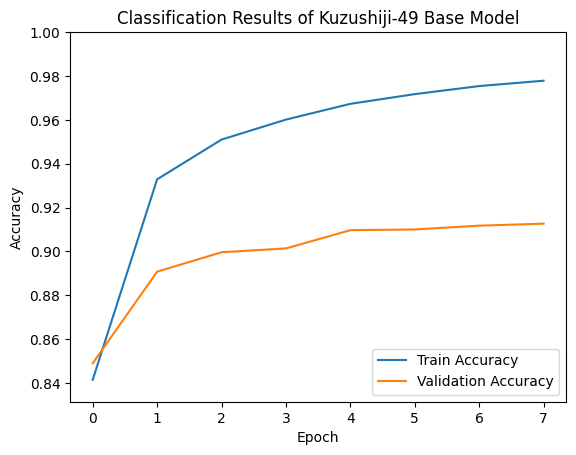

In [11]:
create_visuals("Classification Results of Kuzushiji-49 Base Model", k49_2_history, k49_test_images, k49_train_labels)

## Transfer Learning

In [49]:
# The original Kanji dataset contains images that are 64x64. Since we are transferring the learning
#   from models that trained on 28x28 images, the Kanji images must be downscaled accordingly.
import os
import random
from skimage.transform import rescale
from skimage import io

# Attempt to load a saved model
def attempt_load(name):
    if os.path.isdir(name):
        return models.load_model(name)
    else:
        print(f"Invalid model name {name}")

# Loading a base model requires you pop all dimensionality flattening layers
def load_base_model(filename):
    bm = attempt_load(filename)
    bm.pop()
    bm.pop()
    bm.pop()
    bm.trainable = False
    return bm
        
# Returns a list of the names of the copied directories 
def replicate_folder_structure(original_data, write_path):
    for root, directory, files in os.walk(original_data):
        for direc in directory:
            os.mkdir(write_path + '\\' + direc)

# Scale the image to the desired size
def rescale_image(load_path, save_path, image_scale):
    kanji_char = io.imread(load_path)
    rescaled_image = rescale(kanji_char, image_scale, anti_aliasing=True, clip=True)
    io.imsave(save_path, rescaled_image)

### Prepare the Base Model

In [15]:
tl_base = load_base_model("k49_2_model")

tl_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 average_pooling2d_2 (Averag  (None, 12, 12, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 48)        27696     
                                                                 
Total params: 46,512
Trainable params: 0
Non-trainable params: 46,512
__________________________________________________

## Create the Transfer Learning Model

In [18]:
in_shape = (28, 28, 1)

tl_model = Sequential()
tl_model.add(tl_base)                              # Base..
tl_model.add(Conv2D(48, (3, 3), activation='sigmoid', input_shape=in_shape))
tl_model.add(AveragePooling2D(pool_size=(2, 2)))
tl_model.add(Dropout(0.2))
tl_model.add(Conv2D(32, (3, 3), activation='sigmoid'))
tl_model.add(Flatten())
tl_model.add(Dense(150, activation='relu'))
tl_model.add(Dense(150))

tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10, 10, 48)        46512     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 48)          20784     
                                                                 
 average_pooling2d_2 (Averag  (None, 4, 4, 48)         0         
 ePooling2D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 48)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 32)          13856     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                      

## Train the Transfer Learning Model

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tl_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

tl_model_history = tl_model.fit(kanji_train, batch_size=128, epochs=epochs,
              callbacks=callback, verbose=1, validation_data=kanji_val)

# tl_model.save('tl_model.h5', save_format='h5')

Epoch 1/12
1545/1545 [==============================] - 115s 73ms/step - loss: 2.0925 - sparse_categorical_crossentropy: 4.9825 - accuracy: 0.5289 - val_loss: 0.9316 - val_sparse_categorical_crossentropy: 2.3766 - val_accuracy: 0.7605
Epoch 2/12
1545/1545 [==============================] - 82s 53ms/step - loss: 0.8268 - sparse_categorical_crossentropy: 2.2064 - accuracy: 0.7877 - val_loss: 0.6244 - val_sparse_categorical_crossentropy: 1.7371 - val_accuracy: 0.8375
Epoch 3/12
1545/1545 [==============================] - 81s 53ms/step - loss: 0.6267 - sparse_categorical_crossentropy: 1.7654 - accuracy: 0.8348 - val_loss: 0.5064 - val_sparse_categorical_crossentropy: 1.4735 - val_accuracy: 0.8671
Epoch 4/12
1545/1545 [==============================] - 78s 51ms/step - loss: 0.5192 - sparse_categorical_crossentropy: 1.5557 - accuracy: 0.8642 - val_loss: 0.4416 - val_sparse_categorical_crossentropy: 1.3957 - val_accuracy: 0.8832
Epoch 5/12
1545/1545 [==============================] - 78s 50m

0.9232901930809021
0.924075722694397


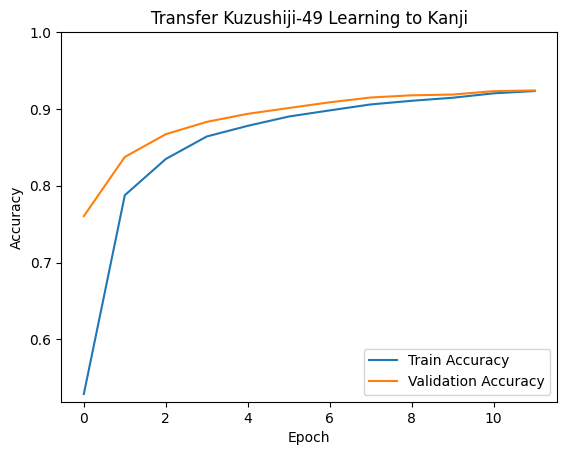

In [20]:
create_visuals("Transfer Kuzushiji-49 Learning to Kanji", tl_model_history, 1, 1)

## Run Optuna Optimization

In [ ]:
def objective(trial):
    # The following is where you suggest your search space per trial (integer, categorical and floating point values)
    l1_filters = trial.suggest_int('first_layer_kernel', 48, 64)
    l1_activation = trial.suggest_categorical('first_layer_activation', ['relu', 'sigmoid', 'tanh'])
    l2_filters = trial.suggest_int('second_layer_kernel', 28, 44)
    l2_activation = trial.suggest_categorical('second_layer_activation', ['relu', 'sigmoid', 'tanh'])
    average_pooling_size = trial.suggest_int('average_pooling_size', 2, 2)
    dense_layer_size = trial.suggest_int('dense_layer_size', 140, 180)
    dense_layer_activation = trial.suggest_categorical('dense_layer_activation', ['relu', 'sigmoid', 'tanh'])
    
    # Load the frozen base model
    base_model = load_base_model('k49_2_model')
    mod_in_shape = (28, 28, 1)
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(l1_filters, (3, 3), activation=l1_activation, input_shape=mod_in_shape))
    model.add(AveragePooling2D((average_pooling_size, average_pooling_size)))
    model.add(Dropout(0.2))
    model.add(Conv2D(l2_filters, (3, 3), activation=l2_activation, input_shape=mod_in_shape))
    model.add(Flatten())
    model.add(Dense(dense_layer_size, activation=dense_layer_activation))
    model.add(Dense(150))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

#     print(model.summary())

    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

    history = model.fit(kanji_train, epochs=15,
                    callbacks=callback, validation_data=kanji_val)

    # Following line is very important as this is the metric that optuna uses to optimize over
    return history.history['val_accuracy'][-1]

# Run a study
study = optuna.create_study(direction='maximize', study_name="Study1")
study.optimize(objective, n_trials=20)

## Find the Best Hyperparameters for the Optuna Model

In [24]:
print(f'Best trial info:\n{study.best_trial}\n')
for param, value in study.best_params.items():
    print(f'Param: {param}\tValue: {value}')

Best trial info:
FrozenTrial(number=14, values=[0.9387128949165344], datetime_start=datetime.datetime(2022, 11, 29, 11, 26, 48, 285783), datetime_complete=datetime.datetime(2022, 11, 29, 11, 40, 2, 11045), params={'first_layer_kernel': 54, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 40, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 172, 'dense_layer_activation': 'tanh'}, distributions={'first_layer_kernel': IntDistribution(high=64, log=False, low=48, step=1), 'first_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 'tanh')), 'second_layer_kernel': IntDistribution(high=44, log=False, low=28, step=1), 'second_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 'tanh')), 'average_pooling_size': IntDistribution(high=2, log=False, low=2, step=1), 'dense_layer_size': IntDistribution(high=180, log=False, low=140, step=1), 'dense_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 

## Build the Optuna Model using Optimized Hyperparameters

In [25]:
kshape = (28, 28, 1)

final_optuna_model = Sequential()
final_optuna_model.add(tl_base)
final_optuna_model.add(Conv2D(54, (3, 3), activation='sigmoid', input_shape=kshape))
final_optuna_model.add(AveragePooling2D((2, 2)))
final_optuna_model.add(Dropout(0.2))
final_optuna_model.add(Conv2D(40, (3, 3), activation='sigmoid', input_shape=kshape))
final_optuna_model.add(Flatten())
final_optuna_model.add(Dense(172, activation='tanh'))
final_optuna_model.add(Dense(150))

final_optuna_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

final_optuna_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10, 10, 48)        46512     
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 54)          23382     
                                                                 
 average_pooling2d_25 (Avera  (None, 4, 4, 54)         0         
 gePooling2D)                                                    
                                                                 
 dropout_25 (Dropout)        (None, 4, 4, 54)          0         
                                                                 
 conv2d_52 (Conv2D)          (None, 2, 2, 40)          19480     
                                                                 
 flatten_25 (Flatten)        (None, 160)               0         
                                                     

## Run the Optuna Model

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

best_optuna_run_history = final_optuna_model.fit(kanji_train, epochs=14,
                            callbacks=callback, validation_data=kanji_val)
# final_optuna_model.save('best_optuna_run.h5', save_format='h5')

Epoch 1/14
1545/1545 [==============================] - 93s 59ms/step - loss: 1.8194 - sparse_categorical_crossentropy: 4.7487 - accuracy: 0.6056 - val_loss: 0.7156 - val_sparse_categorical_crossentropy: 4.1314 - val_accuracy: 0.8307
Epoch 2/14
1545/1545 [==============================] - 104s 67ms/step - loss: 0.6314 - sparse_categorical_crossentropy: 4.1369 - accuracy: 0.8443 - val_loss: 0.4607 - val_sparse_categorical_crossentropy: 4.1359 - val_accuracy: 0.8839
Epoch 3/14
1545/1545 [==============================] - 102s 66ms/step - loss: 0.4718 - sparse_categorical_crossentropy: 4.1355 - accuracy: 0.8801 - val_loss: 0.3847 - val_sparse_categorical_crossentropy: 4.1453 - val_accuracy: 0.9010
Epoch 4/14
1545/1545 [==============================] - 102s 66ms/step - loss: 0.3989 - sparse_categorical_crossentropy: 4.1370 - accuracy: 0.8973 - val_loss: 0.3346 - val_sparse_categorical_crossentropy: 4.1475 - val_accuracy: 0.9136
Epoch 5/14
1545/1545 [==============================] - 104s 

In [28]:
final_optuna_model.save('best_optuna_run.h5', save_format='h5')

# Transfer Learning with Kanji of Size (64, 64)

### Convert the .npz to a Directory of Images

In [13]:
import os
from skimage import io, img_as_uint

# A .npz file is a numpy compression file. All the images are currently loaded into memory.
# This method saves all those images to a directory
def convert_npz_to_images(file_path, npz_file):
    count = 0
    for img in npz_file:
        # Generate file path + file name
        count += 1
        img_name = f"k49-img-{count}.png"
        write_path = file_path + img_name

        # Convert image to supress warnings
        cur_img = img_as_uint(img)

        # Save image to file path
        io.imsave(write_path, cur_img)

In [12]:
# Convert the train.npz and test.npz files through the converter

# train_filepath = '..\..\Datasets\\k49_train_imgs\\'
# test_filepath = '..\..\Datasets\\k49_test_imgs\\'

# convert_npz_to_images(train_filepath, k49_train_images)
# convert_npz_to_images(test_filepath, k49_test_images)

# print("Done!")

C:\Users\LifeH\AppData\Local\Temp\ipykernel_6676\3562458479.py:13: UserWarning: ..\..\Datasets\k49_test_imgs\k49-img-14954.png is a low contrast image
  io.imsave(write_path, cur_img)


Done!


## Place Images in their Respective Class Directories

In [ ]:
# ONLY UNCOMMENT THIS CELL IF:
# You need to convert a flattened directory of K49 images to a directory where all images are in folders
#   of their correct classes

# total_images = len(k49_train_labels)

# for i in range(total_images):
#     cur_label = k49_train_labels[i]
#     cur_image = k49_train_images[i]
#     cur_image = img_as_uint(cur_image)
    
#     file_name = f"K49-image-{i}"
#     save_path = "..\..\Datasets\\k49_train_imgs\\" + str(cur_label) + "\\" + file_name + ".png"
    
#     io.imsave(save_path, cur_image)

# print("Done!")

In [ ]:
# ONLY UNCOMMENT THIS CELL IF:
# You need to convert a flattened directory of K49 images to a directory where all images are in folders
#   of their correct classes

# total_images = len(k49_test_labels)

# for i in range(total_images):
#     cur_label = k49_test_labels[i]
#     cur_image = k49_test_images[i]
#     cur_image = img_as_uint(cur_image)
    
#     file_name = f"K49-image-{i}"
#     save_path = "..\..\Datasets\\k49_test_imgs\\" + str(cur_label) + "\\" + file_name + ".png"
    
#     io.imsave(save_path, cur_image)

# print("Done!")

## Load the K49 Images

In [45]:
# Load new K49 Data
k49_size = (64, 64)
data_path = '..\..\Datasets\\k49_train_imgs'

# The image_dataset_from_directory() method loads images using a default interpolation method of bilinear.
# Other interpolation methods include bicubic, gaussian, nearest, etc.
mod_k49_train = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                            subset="training", color_mode="grayscale", image_size=k49_size, batch_size=32)
print("Done loading train!")
mod_k49_val = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                          subset="validation", color_mode="grayscale", image_size=k49_size, batch_size=32)

print("Done!")

Found 232365 files belonging to 49 classes.
Using 162656 files for training.
Done loading train!
Found 232365 files belonging to 49 classes.
Using 69709 files for validation.
Done!


# Create New Transfer Learning Model

## Create the New Base

In [46]:
# This new base trains on images of size (64, 64)
k49_classes = 49
new_k49_shape = (64, 64, 1)

mod_k49_base = Sequential()
mod_k49_base.add(Conv2D(32, (3, 3), activation='relu', input_shape=new_k49_shape))
mod_k49_base.add(Conv2D(64, (3, 3), activation='relu', input_shape=new_k49_shape))
mod_k49_base.add(Dropout(0.25))
mod_k49_base.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
mod_k49_base.add(Conv2D(48, (3, 3), activation='relu', input_shape=new_k49_shape))
mod_k49_base.add(Flatten())
mod_k49_base.add(Dense(k49_classes, activation='relu'))
mod_k49_base.add(Dense(k49_classes))

mod_k49_base.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

mod_k49_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 64)        0         
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 30, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 48)        27696     
                                                                 
 flatten_1 (Flatten)         (None, 37632)             0         
                                                      

## Run the New Base

In [47]:
epochs = 12
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

mod_k49_base_history = mod_k49_base.fit(mod_k49_train, batch_size=128, epochs=epochs, callbacks=callback, 
                                        verbose=1, validation_data=mod_k49_val)

mod_k49_base.save('mod_k49_base')

Epoch 1/12
5083/5083 [==============================] - 2270s 446ms/step - loss: 0.8132 - sparse_categorical_crossentropy: 2.5928 - accuracy: 0.7933 - val_loss: 0.4641 - val_sparse_categorical_crossentropy: 2.0869 - val_accuracy: 0.8769
Epoch 2/12
5083/5083 [==============================] - 2122s 417ms/step - loss: 0.3798 - sparse_categorical_crossentropy: 1.9618 - accuracy: 0.8970 - val_loss: 0.4079 - val_sparse_categorical_crossentropy: 1.9741 - val_accuracy: 0.8951
Epoch 3/12
5083/5083 [==============================] - 2120s 417ms/step - loss: 0.2623 - sparse_categorical_crossentropy: 1.8129 - accuracy: 0.9253 - val_loss: 0.4706 - val_sparse_categorical_crossentropy: 1.9699 - val_accuracy: 0.8844
Epoch 4/12
5083/5083 [==============================] - 2008s 395ms/step - loss: 0.1902 - sparse_categorical_crossentropy: 1.7235 - accuracy: 0.9436 - val_loss: 0.5566 - val_sparse_categorical_crossentropy: 1.9848 - val_accuracy: 0.8804
Epoch 5/12
5083/5083 [==============================

0.9541547894477844
0.8785092234611511


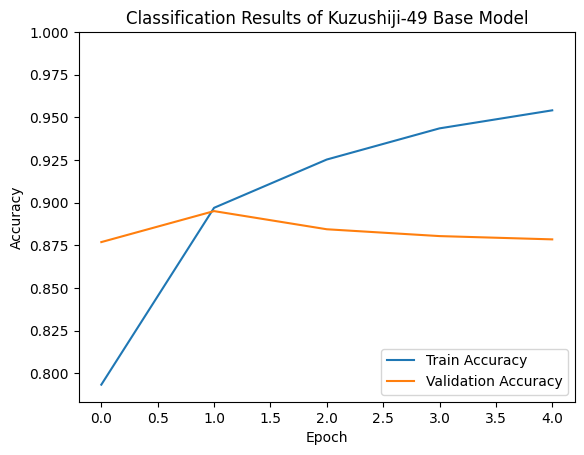

In [65]:
create_visuals("Classification Results of Kuzushiji-49 Base Model", mod_k49_base_history, 1, 1)

## Create the New Top

In [51]:
new_base = load_base_model('mod_k49_base')
in_shape = (64, 64, 1)

mod_tl_model = Sequential()
mod_tl_model.add(new_base)                              # Base..
mod_tl_model.add(Conv2D(48, (3, 3), activation='sigmoid', input_shape=in_shape))
mod_tl_model.add(AveragePooling2D(pool_size=(2, 2)))
mod_tl_model.add(Dropout(0.2))
mod_tl_model.add(Conv2D(32, (3, 3), activation='sigmoid'))
mod_tl_model.add(Flatten())
mod_tl_model.add(Dense(150, activation='relu'))
mod_tl_model.add(Dense(150))

mod_tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 28, 28, 48)        46512     
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 48)        20784     
                                                                 
 average_pooling2d_2 (Averag  (None, 13, 13, 48)       0         
 ePooling2D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 48)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 32)        13856     
                                                                 
 flatten_2 (Flatten)         (None, 3872)              0         
                                                      

## Run the New Top

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

mod_tl_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

mod_tl_model_history = mod_tl_model.fit(kanji_train, batch_size=128, epochs=epochs,
                                      callbacks=callback, verbose=1, validation_data=kanji_val)

# tl_model.save('tl_model.h5', save_format='h5')

Epoch 1/12
5083/5083 [==============================] - 1430s 281ms/step - loss: 0.8718 - sparse_categorical_crossentropy: 3.2459 - accuracy: 0.7724 - val_loss: 0.4229 - val_sparse_categorical_crossentropy: 2.9105 - val_accuracy: 0.8854
Epoch 2/12
5083/5083 [==============================] - 1396s 275ms/step - loss: 0.3556 - sparse_categorical_crossentropy: 2.7916 - accuracy: 0.9028 - val_loss: 0.3352 - val_sparse_categorical_crossentropy: 2.6682 - val_accuracy: 0.9092
Epoch 3/12
5083/5083 [==============================] - 1338s 263ms/step - loss: 0.2796 - sparse_categorical_crossentropy: 2.5741 - accuracy: 0.9225 - val_loss: 0.2909 - val_sparse_categorical_crossentropy: 2.4870 - val_accuracy: 0.9221
Epoch 4/12
5083/5083 [==============================] - 1307s 257ms/step - loss: 0.2359 - sparse_categorical_crossentropy: 2.4209 - accuracy: 0.9338 - val_loss: 0.2828 - val_sparse_categorical_crossentropy: 2.3539 - val_accuracy: 0.9262
Epoch 5/12
5083/5083 [==============================

0.95806485414505
0.9313575029373169


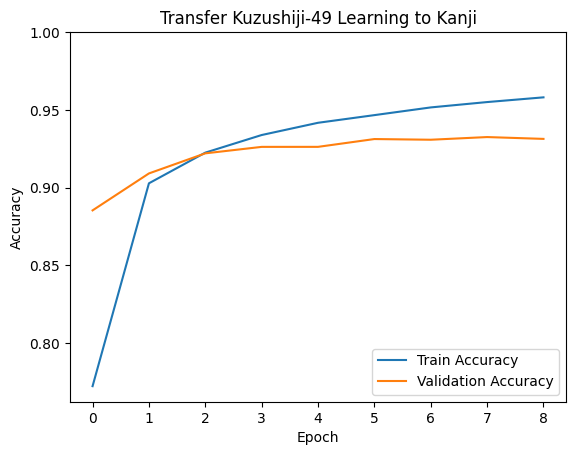

In [67]:
create_visuals("Transfer Kuzushiji-49 Learning to Kanji", mod_tl_model_history, 1, 1)

## A Better Base Model (Testing Purposes)

### Create the Base

In [53]:
# Also trains on images of size (64, 64)
k49_classes = 49
new_k49_shape = (64, 64, 1)

another_k49_base = Sequential()
another_k49_base.add(Conv2D(32, (3, 3), activation='relu', input_shape=new_k49_shape))
another_k49_base.add(Conv2D(64, (3, 3), activation='relu', input_shape=new_k49_shape))
another_k49_base.add(Dropout(0.25))
another_k49_base.add(Conv2D(48, (3, 3), activation='relu', input_shape=new_k49_shape))
another_k49_base.add(Flatten())
another_k49_base.add(Dense(k49_classes, activation='relu'))
another_k49_base.add(Dense(k49_classes))

another_k49_base.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

another_k49_base.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 dropout_3 (Dropout)         (None, 60, 60, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 58, 58, 48)        27696     
                                                                 
 flatten_3 (Flatten)         (None, 161472)            0         
                                                                 
 dense_6 (Dense)             (None, 49)                7912177   
                                                                 
 dense_7 (Dense)             (None, 49)               

### Run the Base

In [54]:
epochs = 12
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

another_k49_base_history = another_k49_base.fit(mod_k49_train, batch_size=128, epochs=epochs, callbacks=callback, 
                                        verbose=1, validation_data=mod_k49_val)

another_k49_base.save('another_k49_base')

Epoch 1/12
5083/5083 [==============================] - 2959s 582ms/step - loss: 1.0432 - sparse_categorical_crossentropy: 2.8283 - accuracy: 0.7539 - val_loss: 0.5537 - val_sparse_categorical_crossentropy: 2.2044 - val_accuracy: 0.8525
Epoch 2/12
5083/5083 [==============================] - 2943s 579ms/step - loss: 0.4554 - sparse_categorical_crossentropy: 2.1619 - accuracy: 0.8756 - val_loss: 0.5007 - val_sparse_categorical_crossentropy: 2.1245 - val_accuracy: 0.8657
Epoch 3/12
5083/5083 [==============================] - 2965s 583ms/step - loss: 0.3024 - sparse_categorical_crossentropy: 2.0204 - accuracy: 0.9138 - val_loss: 0.5359 - val_sparse_categorical_crossentropy: 2.1416 - val_accuracy: 0.8601
Epoch 4/12
5083/5083 [==============================] - 3014s 593ms/step - loss: 0.1960 - sparse_categorical_crossentropy: 1.9171 - accuracy: 0.9410 - val_loss: 0.6180 - val_sparse_categorical_crossentropy: 2.1819 - val_accuracy: 0.8654
Epoch 5/12
5083/5083 [==============================

0.9536506533622742
0.8588130474090576


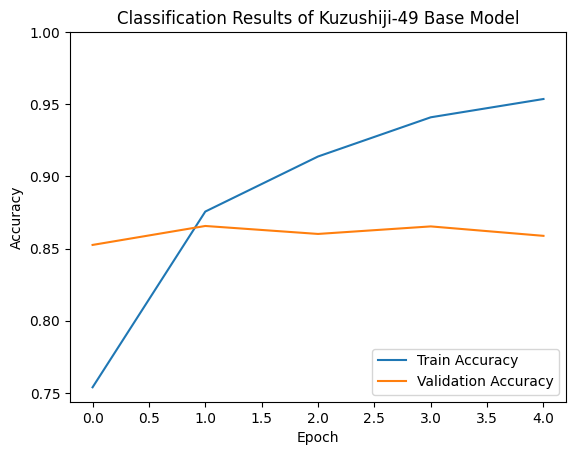

In [70]:
create_visuals("Classification Results of Kuzushiji-49 Base Model", another_k49_base_history, 1, 1)

### Create the Top

In [55]:
new_base = load_base_model('another_k49_base')
in_shape = (64, 64, 1)

another_tl_model = Sequential()
another_tl_model.add(new_base)                              # Base..
another_tl_model.add(Conv2D(48, (3, 3), activation='sigmoid', input_shape=in_shape))
another_tl_model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
another_tl_model.add(Conv2D(48, (3, 3), activation='sigmoid'))
another_tl_model.add(Dropout(0.2))
another_tl_model.add(Conv2D(32, (3, 3), activation='tanh'))
another_tl_model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
another_tl_model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
another_tl_model.add(Flatten())
another_tl_model.add(Dense(150, activation='relu'))
another_tl_model.add(Dense(150))

another_tl_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 58, 58, 48)        46512     
                                                                 
 conv2d_12 (Conv2D)          (None, 56, 56, 48)        20784     
                                                                 
 average_pooling2d_3 (Averag  (None, 28, 28, 48)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 48)        20784     
                                                                 
 dropout_4 (Dropout)         (None, 26, 26, 48)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        13856     
                                                      

### Run the Top

In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

another_tl_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

another_tl_model_history = another_tl_model.fit(kanji_train, batch_size=128, epochs=epochs,
                                      callbacks=callback, verbose=1, validation_data=kanji_val)


Epoch 1/12
5083/5083 [==============================] - 2399s 472ms/step - loss: 0.8783 - sparse_categorical_crossentropy: 2.0633 - accuracy: 0.7699 - val_loss: 0.3582 - val_sparse_categorical_crossentropy: 1.4549 - val_accuracy: 0.9016
Epoch 2/12
5083/5083 [==============================] - 2577s 507ms/step - loss: 0.2898 - sparse_categorical_crossentropy: 1.2613 - accuracy: 0.9190 - val_loss: 0.2797 - val_sparse_categorical_crossentropy: 1.2469 - val_accuracy: 0.9228
Epoch 3/12
5083/5083 [==============================] - 2593s 510ms/step - loss: 0.2146 - sparse_categorical_crossentropy: 1.0301 - accuracy: 0.9389 - val_loss: 0.2532 - val_sparse_categorical_crossentropy: 1.0738 - val_accuracy: 0.9316
Epoch 4/12
5083/5083 [==============================] - 2739s 539ms/step - loss: 0.1732 - sparse_categorical_crossentropy: 0.8690 - accuracy: 0.9501 - val_loss: 0.2499 - val_sparse_categorical_crossentropy: 0.9721 - val_accuracy: 0.9337
Epoch 5/12
5083/5083 [==============================

In [63]:
another_tl_model.save('best_tl_model.h5', save_format='h5')

0.9672499299049377
0.9367083311080933


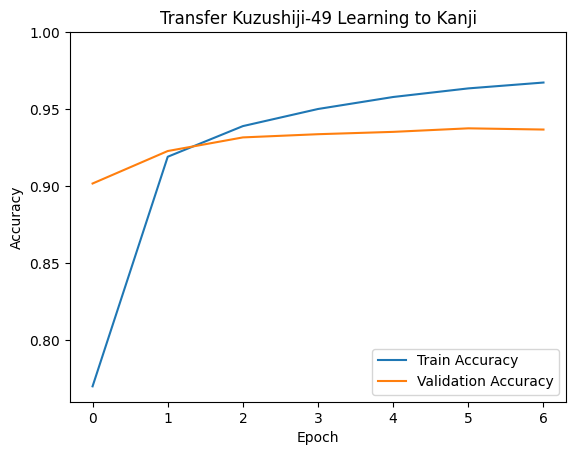

In [68]:
create_visuals("Transfer Kuzushiji-49 Learning to Kanji", another_tl_model_history, 1, 1)